# Download ISIC Challenge Datasets

In [1]:
!wget https://isic-challenge-data.s3.amazonaws.com/2017/ISIC-2017_Training_Data.zip
!wget https://isic-challenge-data.s3.amazonaws.com/2017/ISIC-2017_Training_Part1_GroundTruth.zip
!wget https://isic-challenge-data.s3.amazonaws.com/2017/ISIC-2017_Validation_Data.zip
!wget https://isic-challenge-data.s3.amazonaws.com/2017/ISIC-2017_Validation_Part1_GroundTruth.zip


--2023-02-02 12:15:56--  https://isic-challenge-data.s3.amazonaws.com/2017/ISIC-2017_Training_Data.zip
Resolving isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)... 52.217.48.196, 52.216.42.137, 52.217.34.12, ...
Connecting to isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)|52.217.48.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6229496702 (5.8G) [application/zip]
Saving to: ‘ISIC-2017_Training_Data.zip’

ISIC-2017_Training_ 100%[===================>]   5.80G  14.7MB/s    in 10m 16s 

2023-02-02 12:26:13 (9.64 MB/s) - ‘ISIC-2017_Training_Data.zip’ saved [6229496702/6229496702]

--2023-02-02 12:26:13--  https://isic-challenge-data.s3.amazonaws.com/2017/ISIC-2017_Training_Part1_GroundTruth.zip
Resolving isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)... 3.5.6.179, 52.217.86.28, 52.217.102.28, ...
Connecting to isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amaz

In [2]:
!unzip '/content/ISIC-2017_Training_Data.zip'
!unzip '/content/ISIC-2017_Training_Part1_GroundTruth.zip'

!unzip '/content/ISIC-2017_Validation_Data.zip'
!unzip '/content/ISIC-2017_Validation_Part1_GroundTruth.zip'


Streaming output truncated to the last 5000 lines.
  inflating: ISIC-2017_Training_Data/ISIC_0010078_superpixels.png  
  inflating: ISIC-2017_Training_Data/ISIC_0010080.jpg  
  inflating: ISIC-2017_Training_Data/ISIC_0010080_superpixels.png  
  inflating: ISIC-2017_Training_Data/ISIC_0010081.jpg  
  inflating: ISIC-2017_Training_Data/ISIC_0010081_superpixels.png  
  inflating: ISIC-2017_Training_Data/ISIC_0010086.jpg  
  inflating: ISIC-2017_Training_Data/ISIC_0010086_superpixels.png  
  inflating: ISIC-2017_Training_Data/ISIC_0010087.jpg  
  inflating: ISIC-2017_Training_Data/ISIC_0010087_superpixels.png  
  inflating: ISIC-2017_Training_Data/ISIC_0010088.jpg  
  inflating: ISIC-2017_Training_Data/ISIC_0010088_superpixels.png  
  inflating: ISIC-2017_Training_Data/ISIC_0010089.jpg  
  inflating: ISIC-2017_Training_Data/ISIC_0010089_superpixels.png  
  inflating: ISIC-2017_Training_Data/ISIC_0010090.jpg  
  inflating: ISIC-2017_Training_Data/ISIC_0010090_superpixels.png  
  inflating: 

In [3]:
!rm /content/ISIC-2017_Training_Data/*superpix*
!rm /content/ISIC-2017_Training_Data/*metadata*
!rm /content/ISIC-2017_Validation_Data/*superpix*
!rm /content/ISIC-2017_Validation_Data/*metadata*

# Define Dataset class

In [4]:
import os
import numpy as np
import torch
from PIL import Image


class SkinLesionDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms,images_dir,masks_dir):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.images_dir=images_dir
        self.masks_dir=masks_dir
        self.imgs = list(sorted(os.listdir(os.path.join(root, images_dir))))
        self.masks = list(sorted(os.listdir(os.path.join(root, masks_dir))))

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, self.images_dir, self.imgs[idx])
        mask_path = os.path.join(self.root, self.masks_dir, self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)
        # convert the PIL Image into a numpy array
        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

#Model Definition

In [6]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [7]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.8.2

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 290239, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 290239 (delta 5), reused 7 (delta 2), pack-reused 290208
Receiving objects: 100% (290239/290239), 583.15 MiB | 22.88 MiB/s, done.
Resolving deltas: 100% (265941/265941), done.
Note: switching to 'v0.8.2'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

HEAD is now at 2f40a483d7 [v0.8.X] .circleci: Add Python 3.9 to CI (#3063)


#Define transformation function

In [8]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

# Load Dataset Valid and Train

In [9]:
# use our dataset and defined transformations
dataset = SkinLesionDataset(root='/content',transforms=get_transform(train=True),images_dir='ISIC-2017_Training_Data',masks_dir='ISIC-2017_Training_Part1_GroundTruth')
dataset_valid = SkinLesionDataset(root='/content',transforms=get_transform(train=False),images_dir='ISIC-2017_Validation_Data',masks_dir='ISIC-2017_Validation_Part1_GroundTruth')

# split the dataset in train and test set
torch.manual_seed(1)


# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=16, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_valid = torch.utils.data.DataLoader(
    dataset_valid, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

In [10]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and lesion
num_classes = 2

# get the model using our helper function
model = get_model_instance_segmentation(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


  0%|          | 0.00/170M [00:00<?, ?B/s]

# Train
## you can skip the training process and use our pretrained model

In [ ]:
# let's train it for 15 epochs
from torch.optim.lr_scheduler import StepLR
num_epochs = 15

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=50)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_valid, device=device)
torch.save(model, '/content/model.pt')    

In [11]:
# you can skip the training process and use our pretrained model
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1DEejaITNsHpccNL7MjRdftNzUHnGwdAO' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1DEejaITNsHpccNL7MjRdftNzUHnGwdAO" -O mask_rcnn_lesion.pt && rm -rf /tmp/cookies.txt
Pretrained_model=torch.load('/content/mask_rcnn_lesion.pt')
print(Pretrained_model)

--2023-02-02 12:30:04--  https://docs.google.com/uc?export=download&confirm=t&id=1DEejaITNsHpccNL7MjRdftNzUHnGwdAO
Resolving docs.google.com (docs.google.com)... 108.177.125.139, 108.177.125.102, 108.177.125.113, ...
Connecting to docs.google.com (docs.google.com)|108.177.125.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0o-a0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/odaloadp2o3rmut01elh5bil0eq27pvq/1675341000000/05781975302717187715/*/1DEejaITNsHpccNL7MjRdftNzUHnGwdAO?e=download&uuid=581df734-2aa0-49dd-95b3-3507b8656e36 [following]
--2023-02-02 12:30:05--  https://doc-0o-a0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/odaloadp2o3rmut01elh5bil0eq27pvq/1675341000000/05781975302717187715/*/1DEejaITNsHpccNL7MjRdftNzUHnGwdAO?e=download&uuid=581df734-2aa0-49dd-95b3-3507b8656e36
Resolving doc-0o-a0-docs.googleusercontent.com (doc-0o-a0-docs.googleusercontent.com)... 64.233.189.1

# Pretrained Model Evaluation

### we used colab pro with 25GB RAM 
### if your session restarted when evaluating our model  uncomment the next cell and run it  


In [ ]:
#torch.manual_seed(1)
#indices = torch.randperm(len(dataset_valid)).tolist()
#dataset_valid = torch.utils.data.Subset(dataset_valid, indices[:50])
#data_loader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=1, shuffle=False, num_workers=4,collate_fn=utils.collate_fn)

In [12]:
evaluate(Pretrained_model, data_loader_valid, device=device)

creating index...
index created!
Test:  [  0/150]  eta: 0:25:28  model_time: 9.0813 (9.0813)  evaluator_time: 0.0503 (0.0503)  time: 10.1911  data: 1.0386  max mem: 804
Test:  [100/150]  eta: 0:00:23  model_time: 0.1383 (0.2320)  evaluator_time: 0.2389 (0.1817)  time: 0.5046  data: 0.0259  max mem: 1507
Test:  [149/150]  eta: 0:00:00  model_time: 0.1935 (0.2228)  evaluator_time: 0.5875 (0.3219)  time: 1.3521  data: 0.0573  max mem: 3634
Test: Total time: 0:01:35 (0.6382 s / it)
Averaged stats: model_time: 0.1935 (0.2228)  evaluator_time: 0.5875 (0.3219)
Accumulating evaluation results...
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.622
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.922
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.685
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000


# Test our pretrained model 

In [104]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,15)
import numpy as np

def plot_prediction(image, masks, bboxes, labels,scores,threshold):
    plt.imshow(image)
    ax = plt.gca()
    colors = np.random.rand(len(labels), 3)
    for mask, bbox, label,score, color in zip(masks, bboxes, labels,scores, colors):
      if(score > threshold):
        xmin, ymin, xmax, ymax = bbox
        rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                             fill=False, color=color)
        ax.add_patch(rect)
        ax.text(xmin, ymin, 'lesion  : '+str(score)[:4], fontsize=10,
                bbox=dict(facecolor='yellow', alpha=0.5))
        mask = np.squeeze(mask, axis=0)
        ax.imshow(mask, cmap='Reds', alpha=0.5)
    plt.axis('off')
    plt.show()


# Plot prediction results

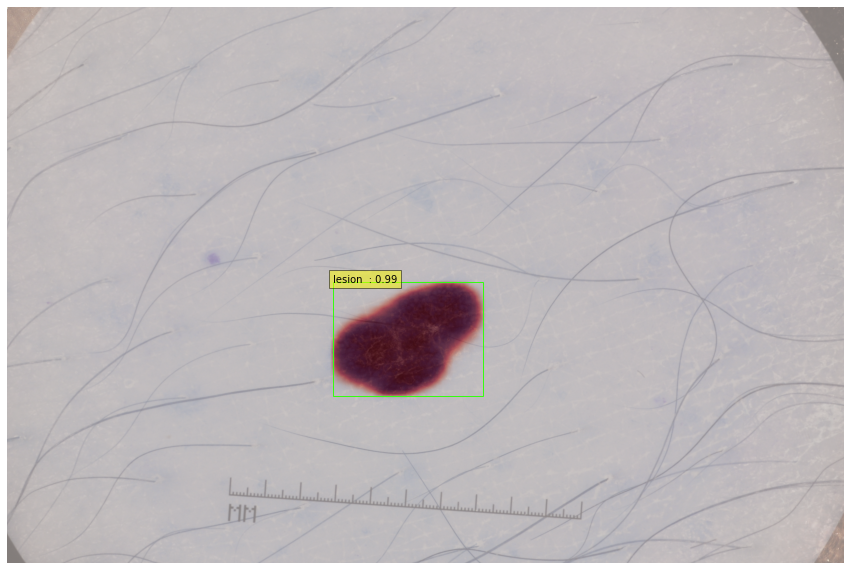

In [105]:
# pick one image from the valid set
from random import random
import cv2 
index=int(random()*len(dataset_valid ))
img, _ = dataset_valid[index]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = Pretrained_model([img.to(device)])
labels=prediction[0]['labels'].cpu().numpy()
bboxes=prediction[0]['boxes'].cpu().numpy()
scores=prediction[0]['scores'].cpu().numpy()
masks=prediction[0]['masks'].cpu().numpy() 
img_path = os.path.join(dataset_valid.root, dataset_valid.images_dir, dataset_valid.imgs[index])
img = cv2.imread(img_path) 
plot_prediction(img, masks, bboxes, labels,scores,0.5)